In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

df = pd.read_pickle('treino.pkl.gz')

df = df[['pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def',
       'pri_emp_abt', 'pri_emp_san', 'pri_emp_tom', 'default']]

In [2]:
def pre_proc_and_split(dataframe, target):

    cols = dataframe.columns.tolist()
    cols.remove(target)
    for i in cols:
        sc = MinMaxScaler()
        dataframe[i] = sc.fit_transform(dataframe[[i]])
    return dataframe[cols], df[target]

def step(scaled_feats, target):
    lr = LogisticRegression()
    lr.fit(scaled_feats, target)
    pred = lr.predict_proba(scaled_feats)
    
    pr = [i[1] for i in pred]

    score = roc_auc_score(y_true = target, y_score = pr) 

    cfs = lr.coef_.tolist()[0]
    cfs = [abs(i) for i in cfs]
    lista = [i for i in zip(cfs, scaled_feats.columns)]
    lista.sort()
    data_cfs = [i[0] for i in lista]
    data_feats = [i[1] for i in lista]

    dropd = lista[0][1]
    lista = lista[1:]
    remaining_feats = [i[1] for i in lista]
    
    return remaining_feats, score, dropd

def my_stepwise(dataframe, target):
    itr = len(dataframe.drop(columns = [target]).columns.tolist()) 
    dici = {}

    for n in range(itr):
    
        scaled_feats, target = pre_proc_and_split(dataframe, 'default')
        remaining, score, dropd = step(scaled_feats, target)
        dici[n] = [score, dataframe.columns.tolist()]
        dataframe = dataframe.drop(columns = [dropd])
        
    return dici

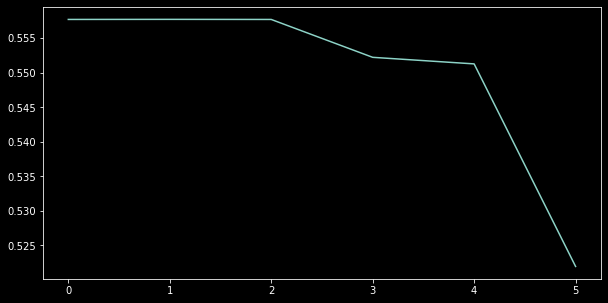

FEATURES INCLUÍDAS EM CADA STEP
0 : ['pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt', 'pri_emp_san', 'pri_emp_tom']
1 : ['pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt', 'pri_emp_san']
2 : ['pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt']
3 : ['pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt']
4 : ['pri_qtd_tot_emp_atv', 'pri_qtd_tot_def']
5 : ['pri_qtd_tot_emp_atv']


In [3]:
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (10, 5)
d = my_stepwise(df, 'default')


plot_vals = []
for i in d.keys():
    plot_vals.append(d[i][0])
    
plt.plot(plot_vals)
plt.show()

print('FEATURES INCLUÍDAS EM CADA STEP')
for i in d.keys():
    fs = d[i][1].remove('default')
    print(i , ':', d[i][1])